In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
from torchvision import transforms
from torch.nn.functional import relu

In [2]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

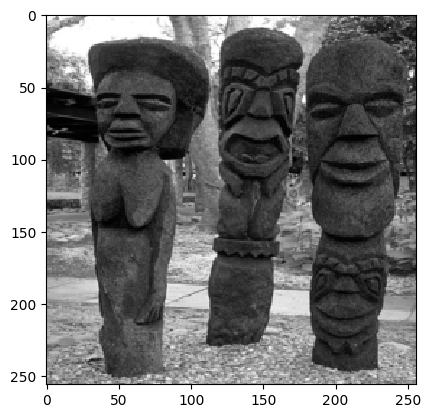

In [3]:
image = Image.open("blurImages/test001.png")
testOutput = preprocess(image).unsqueeze(0)
plt.imshow(testOutput.squeeze().numpy(),cmap='gray',interpolation='none')

In [4]:
class UNetDenoise(nn.Module):
    #layers definition
    def __init__(self): #constructor for uNetDenoise
        super().__init__() #constructor of parent class to init inherited attributes
        #Encoder portion, with 256x256x3 input. Padding: same for 3x3 convolutions

        #1st downsample layer
        self.conv11 = nn.Conv2d(1,64,kernel_size=3, padding=1) #dataset images are black and white
        self.conv12 = nn.Conv2d(64,64, kernel_size=3, padding=1) #keep padding same, (kernselSize-1)/2
        self.pool1=nn.MaxPool2d(kernel_size=2, stride=2)

        #2nd downsample layer
        self.conv21 = nn.Conv2d(64,128,kernel_size=3, padding=1)
        self.conv22 = nn.Conv2d(128,128,kernel_size=3, padding=1)
        self.pool2=nn.MaxPool2d(kernel_size=2, stride=2)

        #3rd downsample layer
        self.conv31 = nn.Conv2d(128,256,kernel_size=3, padding=1)
        self.conv32 = nn.Conv2d(256,256,kernel_size=3, padding=1)
        self.pool3=nn.MaxPool2d(kernel_size=2, stride=2)

        #4th downsample layer
        self.conv41 = nn.Conv2d(256,512,kernel_size=3, padding=1)
        self.conv42 = nn.Conv2d(512,512,kernel_size=3, padding=1)
        self.pool4=nn.MaxPool2d(kernel_size=2, stride=2)

        #bottle neck
        self.conv51 = nn.Conv2d(512,1024,kernel_size=3, padding=1)
        self.conv52 = nn.Conv2d(1024,1024,kernel_size=3, padding=1)

        #upsample 1
        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #1024, but half 
        self.u11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.u12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        #upsample 2
        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.u21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.u22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        #upsample 3
        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.u31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.u32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        #upsample 4
        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.u41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.u42 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        #encoder forward
        xconv11 = relu(self.conv11(x))
        xconv12 = relu(self.conv12(xconv11))
        xpool1 = self.pool1(xconv12)

        xconv21 = relu(self.conv21(xpool1))
        xconv22 = relu(self.conv22(xconv21))
        xpool2 = self.pool2(xconv22)

        xconv31 = relu(self.conv31(xpool2))
        xconv32 = relu(self.conv32(xconv31))
        xpool3 = self.pool3(xconv32)

        xconv41 = relu(self.conv41(xpool3))
        xconv42 = relu(self.conv42(xconv41))
        xpool4 = self.pool4(xconv42)

        xconv51 = relu(self.conv51(xpool4))
        xconv52 = relu(self.conv52(xconv51))

        #decoder forward 
        xup1 = self.upconv1(xconv52)
        xu11 = torch.cat([xup1, xconv42], dim=1)
        xd11 = relu(self.u11(xu11))
        xd12 = relu(self.u12(xd11))

        xup2 = self.upconv2(xd12)
        xu22 = torch.cat([xup2, xconv32], dim=1)
        xd21 = relu(self.u21(xu22))
        xd22 = relu(self.u22(xd21))

        xup3 = self.upconv3(xd22)
        xu33 = torch.cat([xup3, xconv22], dim=1)
        xd31 = relu(self.u31(xu33))
        xd32 = relu(self.u32(xd31))

        xup4 = self.upconv4(xd32)
        xu44 = torch.cat([xup4, xconv12], dim=1)
        xd41 = relu(self.u41(xu44))
        xd42 = relu(self.u42(xd41))

        return xd42

In [5]:
class BlurModel(nn.Module):
    def __init__(self):
        super(BlurModel, self).__init__()

        self.k = torch.tensor([[1/16,1/8,1/16],[1/8,1/4,1/8],[1/16,1/8,1/16]],dtype=torch.float32) # set blur kernel
        self.k = self.k.view(1,1,3,3)
    def forward(self, x, sigma=0):
        # A y
        x_padded = F.pad(x, (1,1,1,1), mode='circular')
        y = F.conv2d(x_padded, self.k) + sigma * torch.randn_like(x)
        return y
    
    def tran(self, y):
        # A^T y
#         x = NotImplemented # hint: transpose the blur kernel
        y_padded = F.pad(y, (1, 1, 1, 1), mode='circular')
        #kTranposed = self.k.t()
        x = F.conv2d(y_padded, self.k, padding=0) #self.k is symmetric
        return x
    
    def grad(self, x, y):
        # gradient of 0.5 || Ax - y ||^2 --> grad = A^T(Ax - y)
        g = self.tran( self.forward(x) - y )
        return g

In [6]:
def run_PnP_ISTA(
             x0,
             A, 
             denoiser,
             meas, 
             stepsize,
             gt_img, 
             max_iter,
            ):
    # ############################
    # A basic implementation of PnP ISTA
    # ############################
    x = x0
    for i in tqdm(range(max_iter)):
        # Look at PnP ISTA update steps
        z = x - stepsize*A.grad(x, meas) #prev x - stepsize*grad(prev x)
        x = denoiser(z)
    
        # Feel free to add psnr/ssim tracking
    
        
    return x

In [7]:
max_iter = 70
stepsize = 1e-1 # play with this
meas_sigma = 15 / 255 # play with this (note that it does not need to be same as the sigma you used for training)

A = BlurModel() # forward model

clean_img = preprocess(image).unsqueeze(0)

blurry_img = A(clean_img, sigma=meas_sigma)

network = UNetDenoise()
network.load_state_dict(torch.load('denoiserModelBestWeights.pth')) # Your NN you trained
network.eval()

x0 = torch.zeros_like(blurry_img)

recon = run_PnP_ISTA(x0 = x0, # For deblurring, initializing with the blurry image can work
                     A = A, 
                     denoiser = network,
                     meas = blurry_img, 
                     stepsize = stepsize,
                     gt_img = clean_img, 
                     max_iter = max_iter
                )


100%|██████████| 70/70 [00:43<00:00,  1.60it/s]


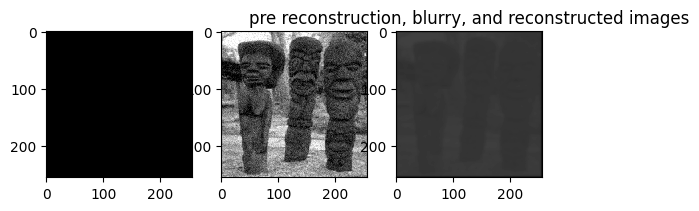

In [11]:
fig, ax = plt.subplots(1,3)
plt.title("pre reconstruction, blurry, and reconstructed images")
ax[0].imshow(x0[0,0].numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[1].imshow(blurry_img[0,0].numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
ax[2].imshow(recon[0,0].detach().numpy(), vmin=0, vmax=1,cmap='gray',interpolation='none')
# ax[0].imshow(x0[0,0].squeeze().numpy(),cmap='gray',interpolation='none')
# ax[1].imshow(blurry_img[0,0].squeeze().numpy(),cmap='gray',interpolation='none')
# ax[2].imshow(recon[0,0].squeeze().numpy(),cmap='gray',interpolation='none')
